<a href="https://colab.research.google.com/github/lili-codelab/comp-linguistics/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **RNN/LSTM**

Цель семинара: получить практический опыт работы с RNN (LSTM) в PyTorch на задачах генерации последовательностей

Мы разберем полный пайплайн разработки от препроцессинга данных до обучения и экспериментов с гиперпараметрами

Кстати, что мы называем **пайплайном**?

В Google Colab (рекомендуется активировать GPU: `Среда выполнения → Сменить среду выполнения → T4 GPU`)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

### **ЧАСТЬ 1: ДЕМО**
*   **Задача модели:** предсказание случайного временного ряда (синусоида)
*   **Цель демонстрации:** показать полный и минимальный рабочий пайплайн RNN на задаче, связанной с обработкой данных, передающих изменения во времени
*   **План:**
    1.  Подготовка последовательностей (sequences)
    2.  Архитектура `nn.LSTM`
    3.  Обучение модели
    4.  Получение метрик оценки
    5.  Визуализация и интерпретация результата

### 1. ГЕНЕРАЦИЯ И ПОДГОТОВКА ДАННЫХ

In [ ]:
def generate_sine_wave(seq_length=1000, periods=5):
    """Генерация синусоиды."""
    x = np.linspace(0, periods * 2 * np.pi, seq_length)
    y = np.sin(x)
    return y

# Генерация данных
data = generate_sine_wave()
print(f"Длина временного ряда: {len(data)}")

Длина временного ряда: 1000


In [ ]:
# Параметры последовательностей
SEQ_LEN = 50  # Длина входной последовательности для предсказания
BATCH_SIZE = 16

In [ ]:
def create_sequences(data, seq_len):
    """Создание пар (входная последовательность, целевое значение)."""
    sequences = []
    targets = []
    for i in range(len(data) - seq_len - 1):
        seq = data[i:i + seq_len]
        target = data[i + seq_len]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [ ]:
# Создание последовательностей
X, y = create_sequences(data, SEQ_LEN)
print(f"Форма X (последовательности): {X.shape}")
print(f"Форма y (цели): {y.shape}")

Форма X (последовательности): (949, 50)
Форма y (цели): (949,)


In [ ]:
# Преобразование в тензоры PyTorch и добавление размерности для признаков
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # [примеры, SEQ_LEN, 1]
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # [примеры, 1]
print(f"Форма X (тензор): {X.shape}")
print(f"Форма y (тензор): {y.shape}")

Форма X (тензор): torch.Size([949, 50, 1])
Форма y (тензор): torch.Size([949, 1])


In [ ]:
# Разделение на обучающую и тестовую выборки
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
### 2. ОПРЕДЕЛЕНИЕ МОДЕЛИ LSTM
class SineLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # формат [batch, seq_len, features]
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Инициализация скрытого состояния и состояния ячейки
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Прямой проход через LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Берем только последний выход последовательности для предсказания
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Инициализация модели
model = SineLSTM()
print(f"Модель:\n{model}")

Модель:
SineLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


### 3. ОБУЧЕНИЕ МОДЕЛИ

In [ ]:
# Гиперпараметры
EPOCHS = 20
LEARNING_RATE = 0.01

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Тренировочный цикл
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()

    # Прямой проход
    predictions = model(X_train)
    loss = criterion(predictions, y_train)

    # Обратное распространение
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Оценка на тестовой выборке
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)
        test_loss = criterion(test_predictions, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f'Эпоха [{epoch+1}/{EPOCHS}], '
              f'Ошибка обучения: {loss.item():.6f}, '
              f'Ошибка теста: {test_loss.item():.6f}')

Эпоха [5/20], Ошибка обучения: 0.742966, Ошибка теста: 0.078289
Эпоха [10/20], Ошибка обучения: 0.203131, Ошибка теста: 0.204805
Эпоха [15/20], Ошибка обучения: 0.041399, Ошибка теста: 0.024017
Эпоха [20/20], Ошибка обучения: 0.062450, Ошибка теста: 0.040246


### 4. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

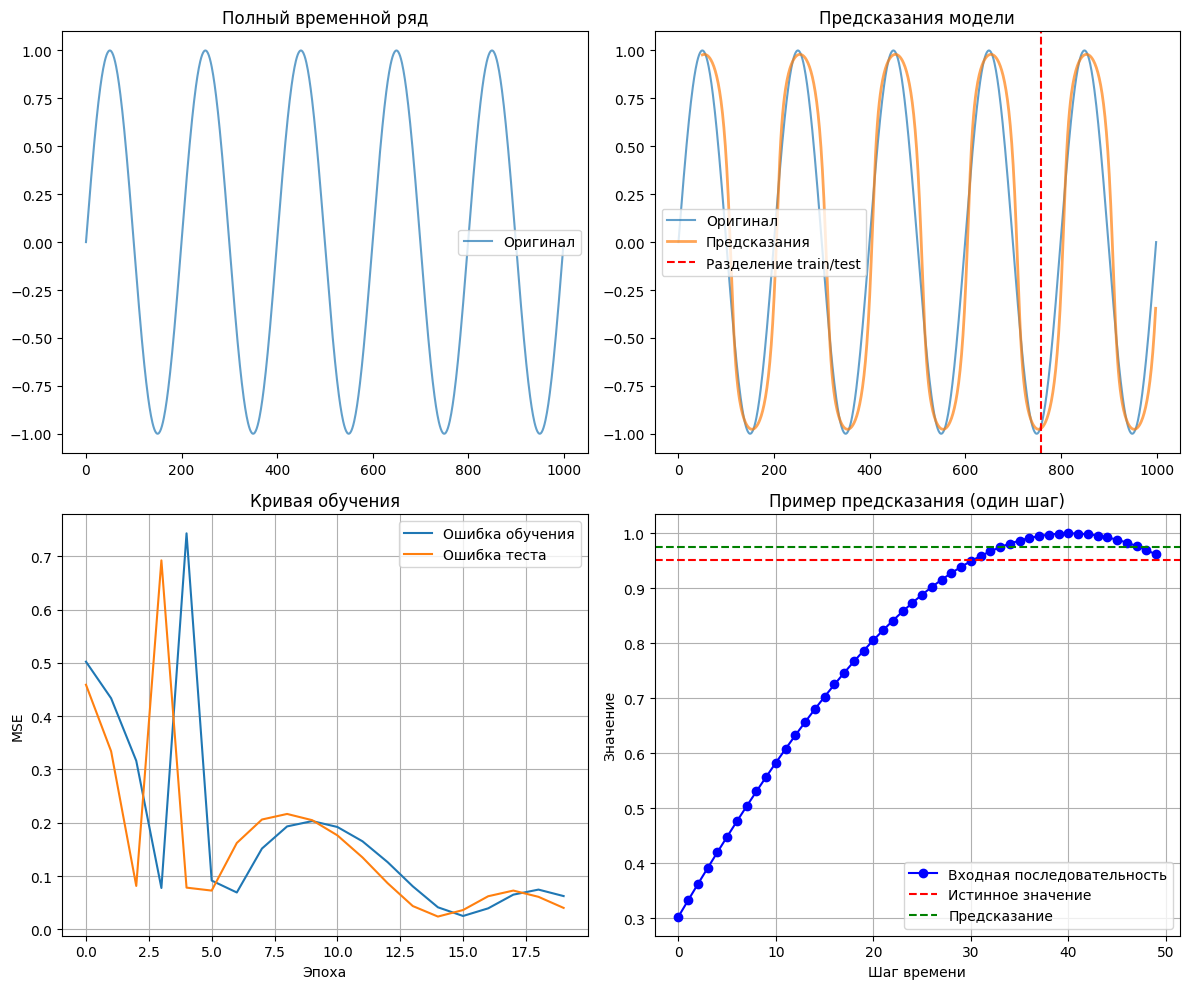

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# График 1: Оригинальные данные и предсказания
axes[0, 0].plot(data, label='Оригинал', alpha=0.7)
axes[0, 0].set_title('Полный временной ряд')
axes[0, 0].legend()

# График 2: Предсказания на тестовой выборке
model.eval()
with torch.no_grad():
    all_predictions = model(X).numpy()

# Создание массива для отображения предсказаний
pred_series = np.full_like(data, np.nan)
pred_series[SEQ_LEN:SEQ_LEN + len(all_predictions)] = all_predictions.squeeze()

axes[0, 1].plot(data, label='Оригинал', alpha=0.7)
axes[0, 1].plot(pred_series, label='Предсказания', alpha=0.7, linewidth=2)
axes[0, 1].axvline(x=split_idx, color='r', linestyle='--', label='Разделение train/test')
axes[0, 1].set_title('Предсказания модели')
axes[0, 1].legend()

# График 3: Ошибки обучения и теста
axes[1, 0].plot(train_losses, label='Ошибка обучения')
axes[1, 0].plot(test_losses, label='Ошибка теста')
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].set_title('Кривая обучения')
axes[1, 0].legend()
axes[1, 0].grid(True)

# График 4: Пример одного предсказания
sample_idx = split_idx + 50
axes[1, 1].plot(range(SEQ_LEN), X[sample_idx].squeeze().numpy(),
                'bo-', label='Входная последовательность')
axes[1, 1].axhline(y=y[sample_idx].item(), color='r', linestyle='--',
                   label='Истинное значение')
axes[1, 1].axhline(y=all_predictions[sample_idx].item(), color='g',
                   linestyle='--', label='Предсказание')
axes[1, 1].set_xlabel('Шаг времени')
axes[1, 1].set_ylabel('Значение')
axes[1, 1].set_title('Пример предсказания (один шаг)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

### 5. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ
1. Кривая обучения должна снижаться на обеих выборках
2. Предсказания должны следовать за оригинальным рядом
3. Разрыв между train/test loss указывает на переобучение
4. Модель учится предсказывать следующий шаг синусоиды

Take aways:

1. Подготовка последовательностей: как из временного ряда создаются пары (окно истории -> целевое значение)?

2. Архитектура LSTM: batch_first=True, почему берем out[:, -1, :]

3. Цикл обучения: разделение на model.train() и model.eval(), логика .zero_grad(), .backward(), .step()

4. Визуализация: как интерпретировать каждый из 4-х графиков?

---

# ПРАКТИКА

1. ЗАГРУЗКА И ПРЕДВАРИТЕЛЬНЫЙ ПРОСМОТР ДАННЫХ

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

# TODO 1.1: Загрузите датасет Reuters
(x_train, y_train), (x_test, y_test) = # ... Ваш код здесь ...

# TODO 1.2: Изучите структуру данных
print("Тип x_train:", type(x_train))
print("Длина x_train:", # ... Ваш код здесь ... )
print("Первая последовательность (первые 10 индексов):", # ... Ваш код здесь ... )
print("Длина первой последовательности:", # ... Ваш код здесь ... )

2. ПОДГОТОВКА СЛОВАРЯ И ДЕКОДИРОВАНИЕ

In [ ]:
# TODO 2.1: Загрузите словарь слов
word_index = # ... Ваш код здесь ...
reverse_word_index = {value: key for (key, value) in word_index.items()}

# TODO 2.2: Реализуйте функцию декодирования последовательности
def decode_sequence(sequence):
    return # ... Ваш код здесь ...

first_article = decode_sequence(x_train[0])
print("\nПервая статья (первые 200 символов):", first_article[:200])

3. ПОДГОТОВКА ДАННЫХ ДЛЯ ГЕНЕРАЦИИ ТЕКСТА

In [ ]:
# TODO 3.1: Объедините первые 1000 статей в один текст
max_articles = 1000
all_text = # ... Ваш код здесь ...

print(f"\nОбщая длина текста (символов): {len(all_text)}")

# TODO 3.2: Создайте словари для преобразования символов в индексы и обратно
chars = # ... Ваш код здесь ...
char_to_idx = # ... Ваш код здесь ...
idx_to_char = # ... Ваш код здесь ...

vocab_size = len(chars)
print(f"Размер словаря (уникальных символов): {vocab_size}")

# TODO 3.3: Преобразуйте текст в последовательность индексов
text_as_int = # ... Ваш код здесь ...

4. ФОРМИРОВАНИЕ ПРОМПТОВ И ОТВЕТОВ

In [ ]:
seq_length = 100

# TODO 4.1: Реализуйте функцию create_sequences для создания обучающих примеров
def create_sequences(text_indices, seq_len):
    input_seq = []
    target_seq = []

    # ... Ваш код здесь ...

    return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

input_seq, target_seq = create_sequences(text_as_int, seq_length)

print(f"\nКоличество примеров: {len(input_seq)}")
print(f"Форма input_seq: {input_seq.shape}")
print(f"Форма target_seq: {target_seq.shape}")

# TODO 4.2: Создайте DataLoader для пакетной обработки
batch_size = 32
dataset = # ... Ваш код здесь ...
dataloader = # ... Ваш код здесь ...

5. ОПРЕДЕЛЕНИЕ МОДЕЛИ LSTM

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=2, embedding_dim=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # TODO 5.1: Определите слои модели
        self.embedding = # ... Ваш код здесь ...
        self.lstm = # ... Ваш код здесь ...
        self.fc = # ... Ваш код здесь ...

    def forward(self, x, hidden=None):
        # TODO 5.2: Реализуйте forward pass
        # Шаг 1: Примените слой эмбеддинга
        embedded = # ... Ваш код здесь ...

        # Шаг 2: Прямой проход через LSTM
        if hidden is None:
            lstm_out, hidden = # ... Ваш код здесь ...
        else:
            lstm_out, hidden = # ... Ваш код здесь ...

        # Шаг 3: Возьмите только последний выход LSTM
        lstm_out = # ... Ваш код здесь ...

        # Шаг 4: Примените полносвязный слой
        output = # ... Ваш код здесь ...

        return output, hidden

# TODO 5.3: Инициализируйте модель
model = # ... Ваш код здесь ...
print(f"\nМодель:\n{model}")

6. ОБУЧЕНИЕ МОДЕЛИ

In [ ]:
EPOCHS = 4
LEARNING_RATE = 0.005

# TODO 6.1: Определите функцию потерь и оптимизатор
criterion = # ... Ваш код здесь ...
optimizer = # ... Ваш код здесь ...

# TODO 6.2: Реализуйте функцию генерации текста
def generate_text(model, seed_text, length=100, temperature=1.0):
    model.eval()
    generated = seed_text

    # ... Ваш код здесь ...

    return generated

# TODO 6.3: Реализуйте тренировочный цикл
train_losses = []

print("\nНачало обучения...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_idx, (batch_input, batch_target) in enumerate(dataloader):
        # ... Ваш код здесь ...
        # Включая: zero_grad, forward pass, backward, step

    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 2 == 0:
        seed = "The company said"
        generated = generate_text(model, seed, length=50, temperature=0.8)
        print(f'\nЭпоха [{epoch+1}/{EPOCHS}], Средняя ошибка: {avg_loss:.4f}')
        print(f'Сгенерированный текст: "{generated}"')

---

# ДОМАШНЕЕ ЗАДАНИЕ (дедлайн: 13 февраля, 23.59)

**Задача:** обучить модель с разными гиперпараметрами

1. Набор A: hidden_size=64, num_layers=1, learning_rate=0.01

2. Набор B: hidden_size=256, num_layers=2, learning_rate=0.001

3. Набор C: любой произвольный набор параметров hidden_size, num_layers, learning_rate, отличный от предложенных

Сравните:

- Скорость сходимости (график loss)
- Качество генерации (осмысленность текста)
- Время обучения

### **ВОПРОСЫ ДЛЯ РЕФЛЕКСИИ**

1.  Какие ключевые отличия вы заметили в подготовке данных для числового ряда (синусоида) и текста?

2.  Какой опыт работы с PyTorch (например, отладка, подбор параметров) оказался самым полезным?